In [2]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import prec_recall as pr

In [28]:
results = h5py.File("glove-25-100k-1k.hdf5", "r")
data = h5py.File("../../data/glove-25-angular.hdf5", "r")

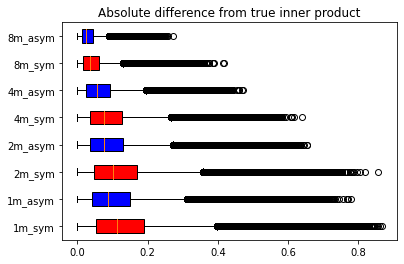

In [5]:
inner_prods = results["True_innner_product"][:]
inner_prods = inner_prods.reshape(inner_prods.shape[0] * inner_prods.shape[1])
all_diffs = []
labels = []
for m in [ 2**val for val in range(0,4)]:
    name = "%dm" % m
    symd    = results[name]["Symmetric_distance"][:]
    asymd   = results[name]["Asymmetric_distance"][:]
    symd = symd.reshape(symd.shape[0]*symd.shape[1])
    asymd = asymd.reshape(asymd.shape[0]*asymd.shape[1])
    symd_diff = np.abs(inner_prods - symd)
    asymd_diff = np.abs(inner_prods - asymd)
    all_diffs.append(symd_diff)
    labels.append(name + "_sym")
    all_diffs.append(asymd_diff)
    labels.append(name + "_asym")

bplot = plt.boxplot(all_diffs, vert=False, patch_artist=True, labels=labels)
for idx, patch in enumerate(bplot["boxes"]):
    patch.set_facecolor("red" if (idx%2==0) else "blue")

plt.title("Absolute difference from true inner product")
plt.show()



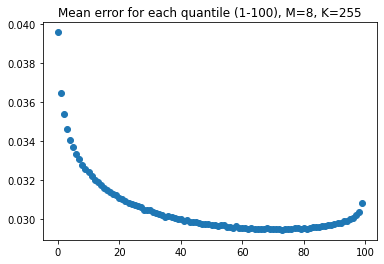

In [6]:
order = np.argsort(inner_prods)
m8_a = results["8m"]["Asymmetric_distance"][:]

m8_a = m8_a.reshape(m8_a.shape[0] * m8_a.shape[1])
m8_a_diffs = np.abs(inner_prods - m8_a)
m8_a_diffs = m8_a_diffs[order]
ordered_inner = inner_prods[order]

bins = 100
step = ordered_inner.shape[0]//bins

avgs = []
for i in range(bins):
    m8_a_sec = m8_a_diffs[i*step:(i+1)*step]
    avgs.append(np.mean(m8_a_sec))

scat = plt.scatter(range(bins),avgs)
plt.title("Mean error for each quantile (1-100), M=8, K=255")
plt.show()

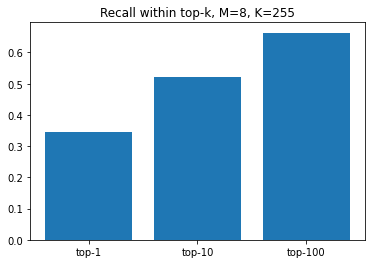

In [7]:

recalls = [0 for _ in range(3)]
for q, ans in zip(results["8m"]["Asymmetric_distance"], results["True_innner_product"]): 
    q_order = np.argsort(q)
    ans_order = np.argsort(ans)
    for i in range(3):
        top_k = 10**i
        intersection = np.intersect1d(q_order[:top_k], ans_order[:top_k])
        recalls[i]+= len(intersection)
for i in range(3):
    recalls[i] /= ((10**i)*results["True_innner_product"].shape[0])
plt.title("Recall within top-k, M=8, K=255")
plt.bar(["top-%d" % 10**i for i in range(3)], recalls)
plt.show()



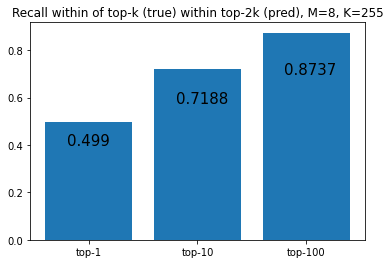

In [8]:
recalls = [0 for _ in range(3)]
for q, ans in zip(results["8m"]["Asymmetric_distance"], results["True_innner_product"]): 
    q_order = np.argsort(q)
    ans_order = np.argsort(ans)
    for i in range(3):
        top_k = 10**i
        intersection = np.intersect1d(q_order[:top_k*2], ans_order[:top_k])
        recalls[i]+= len(intersection)
for i in range(3):
    recalls[i] /= ((10**i)*results["True_innner_product"].shape[0])
plt.title("Recall within of top-k (true) within top-2k (pred), M=8, K=255")
plt.bar(["top-%d" % 10**i for i in range(3)], recalls)

for i in range(3):
    plt.text(x = i-0.2, y = recalls[i]-0.2*recalls[i], s = str(recalls[i]), size = 15)
plt.show()


In [13]:
bins = 100

needed = [[] for _ in range(bins)]
for q, ans in zip(results["8m"]["Asymmetric_distance"], results["True_innner_product"]): 
    q_order = np.argsort(q)
    ans_order = np.argsort(ans)
    for i in range(bins):
        top_k = i+1
        set_ans_order = set(ans_order[:top_k])
        j = 0
        while len(set_ans_order) > 0:
            if q_order[j] in set_ans_order:
                set_ans_order.remove(q_order[j])
            j += 1
        needed[i].append(j)
need_arr = np.array(needed)



In [49]:
colormap = cm.get_cmap("Reds")
p = 11
percentiles = np.linspace(0,100,p)
p_data = np.zeros((need_arr.shape[0], p))
half = (p-1)//2
for i, row in enumerate(need_arr):
    row_p = np.percentile(row, percentiles)
    for j in range(p):
        p_data[i,j] = row_p[j]


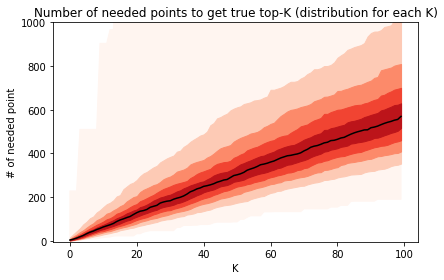

In [50]:
x_vals = list(range(bins))
plt.plot(x_vals, p_data[:,half], color="k")
for i in range(half):
    plt.fill_between(x_vals, p_data[:,i], p_data[:,-(i+1)], color = colormap(i/half))
plt.title("Number of needed points to get true top-K (distribution for each K)")
plt.xlabel("K")
plt.ylabel("# of needed point")
plt.tight_layout()
plt.gca().set_ylim([-5, 1000])
plt.show()

In [32]:
recalls = np.zeros((3,10))
for q, ans in zip(results["8m"]["Asymmetric_distance"], results["True_innner_product"]): 
    q_order = np.argsort(q)
    ans_order = np.argsort(ans)
    for i in range(1,11):
        for pow in range(3):
            top_k = 10**pow
            intersection = np.intersect1d(q_order[:top_k*i], ans_order[:top_k])
            recalls[pow,(i-1)]+= len(intersection)
recalls[0,:] /= results["True_innner_product"].shape[0]
recalls[1,:] /= 10*results["True_innner_product"].shape[0]
recalls[2,:] /= 100*results["True_innner_product"].shape[0]

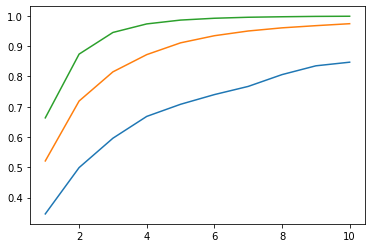

In [34]:
plt.plot(range(1,11),recalls[0])
plt.plot(range(1,11),recalls[1])
plt.plot(range(1,11),recalls[2])

### Comparing mahalanobis optimization to euclidean optimization

In [3]:
maha_euc_r = h5py.File("euc_maha_comp.hdf5", "a")

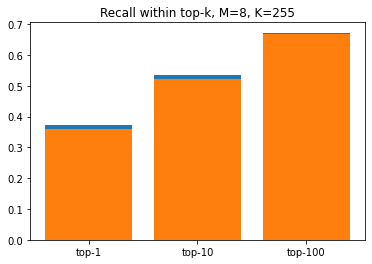

In [9]:
maha_recalls = [0 for _ in range(3)]
euc_recalls = [0 for _ in range(3)]
for q_maha, q_euc, ans in zip(maha_euc_r["8m"]["Maha_dist_asym"], maha_euc_r["8m"]["Euc_dist_asym"], maha_euc_r["True_innner_product"]): 

    q_maha_order = np.argsort(q_maha)
    q_euc_order =  np.argsort(q_euc)
    ans_order = np.argsort(ans)

    for i in range(3):
        top_k = 10**i
        maha_intersection = np.intersect1d(q_maha_order[:top_k], ans_order[:top_k])
        euc_intersection = np.intersect1d(q_euc_order[:top_k], ans_order[:top_k])
        maha_recalls[i]+= len(maha_intersection)
        euc_recalls[i]+= len(euc_intersection)
    
for i in range(3):
    maha_recalls[i] /= ((10**i)*maha_euc_r["True_innner_product"].shape[0])
    euc_recalls[i]  /= ((10**i)*maha_euc_r["True_innner_product"].shape[0])

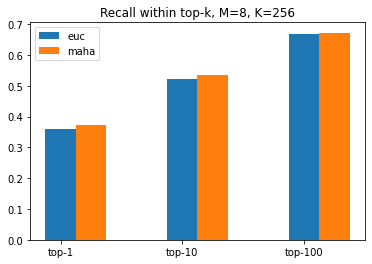

In [20]:
barWidth = 0.25
plt.title("Recall within top-k, M=8, K=256")
x_labels = ["top-%d" % 10**i for i in range(3)]
br1 = np.arange(3)
br2 = [x + barWidth for x in br1]
plt.bar(br1, euc_recalls, label = "euc", width = barWidth )
plt.bar(br2, maha_recalls, label = "maha", width = barWidth )
plt.xticks([r + barWidth//2 for r in range(3)],
        x_labels)
plt.legend()
plt.show()

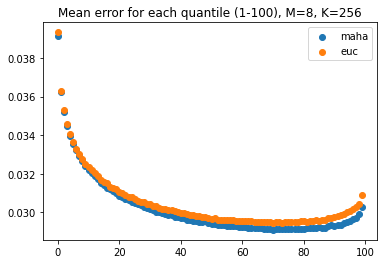

In [26]:
inner_prods = maha_euc_r["True_innner_product"][:].reshape(-1)
order = np.argsort(inner_prods)

maha_m8_a = maha_euc_r["8m"]["Maha_dist_asym"][:]
euc_m8_a = maha_euc_r["8m"]["Euc_dist_asym"][:]

maha_m8_a = maha_m8_a.reshape(maha_m8_a.shape[0] * maha_m8_a.shape[1])
euc_m8_a  = euc_m8_a.reshape(euc_m8_a.shape[0] * euc_m8_a.shape[1])

maha_m8_a_diffs = np.abs(inner_prods - maha_m8_a)
euc_m8_a_diffs = np.abs(inner_prods - euc_m8_a)

maha_m8_a_diffs = maha_m8_a_diffs[order]
euc_m8_a_diffs = euc_m8_a_diffs[order]

ordered_inner = inner_prods[order]

bins = 100
step = ordered_inner.shape[0]//bins

maha_avgs = []
euc_avgs = []
for i in range(bins):
    maha_m8_a_sec = maha_m8_a_diffs[i*step:(i+1)*step]
    euc_m8_a_sec  = euc_m8_a_diffs[i*step:(i+1)*step]
    maha_avgs.append(np.mean(maha_m8_a_sec))
    euc_avgs.append(np.mean(euc_m8_a_sec))

plt.scatter(range(bins),maha_avgs, label = "maha")
plt.scatter(range(bins),euc_avgs, label = "euc")
plt.title("Mean error for each quantile (1-100), M=8, K=256")
plt.legend()
plt.show()

In [29]:
euc = h5py.File("inertia_variance_euc.hdf5", "r")
maha = h5py.File("inertia_variance_maha.hdf5", "r")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.9928739164374041 1.007126083562596
0.0023753611875319833


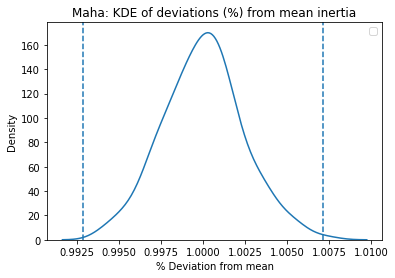

In [3]:
maha = h5py.File("inertia_variance_maha.hdf5", "r")
d = None
std = 0
k = None
w = None

all_d = []
for key in maha.keys():
    c_d = maha[key]/np.mean(maha[key])
    all_d.append(c_d)
all_d = np.concatenate(all_d)
std = np.std(all_d)
lb = 1 - 3*std
ub = 1 + 3*std
print(lb, ub)
print(std)

plt.axvline(lb, linestyle="--")
plt.axvline(ub, linestyle="--")
sns.kdeplot(all_d)
plt.title("Maha: KDE of deviations (%) from mean inertia")
plt.xlabel("% Deviation from mean")
plt.legend()
plt.show()

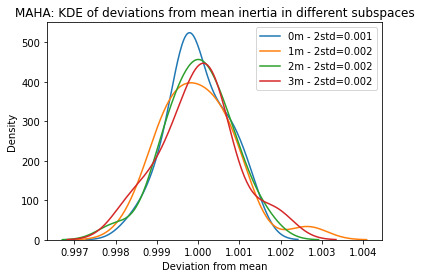

In [32]:
for key in maha.keys():
    m = np.mean(maha[key])
    d = maha[key]/m
    std2 = 2 * np.std(d)
    sns.kdeplot(d, label = key + " - 2std=%0.3f" % std2)
plt.title("MAHA: KDE of deviations from mean inertia in different subspaces")
plt.xlabel("Deviation from mean")
plt.legend()
plt.show()

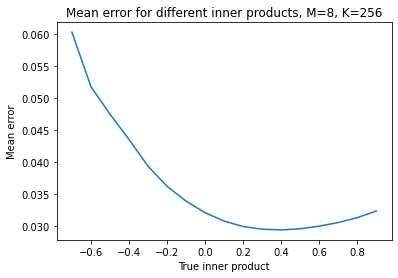

In [19]:

test = h5py.File("test.hdf5", "r")

inner_prods = test["True_innner_product"][:].reshape(-1)
order = np.argsort(inner_prods)

m4_a = test["8m"]["Asymmetric_distance"][:]

m4_a = m4_a.reshape(-1)

diffs = np.abs(inner_prods - m4_a)

diffs = diffs[order]

ordered_inner = inner_prods[order]

bins = 100
step_size = 0.1

prev = 0
bin = -0.9
xs = []
ys = []
while bin <= 1:
    new = np.argmax(ordered_inner > bin)
    section = diffs[prev:new]
    if section.shape[0]:
        xs.append(bin)
        ys.append(np.mean(section))

    prev = new
    bin += step_size

plt.plot(xs,ys)
plt.title("Mean error for different inner products, M=8, K=256")
plt.xlabel("True inner product")
plt.ylabel("Mean error")
plt.show()

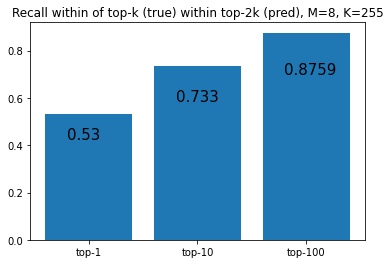

df = pd.DataFrame(np.array(), columns=["Estimated", "True"])

In [5]:
df.head(20)

,Estimated,True
0,0.987946,0.986572
1,0.931580,0.982178
2,0.966034,0.979279
3,0.993866,0.973969
4,0.916351,0.972260
5,0.939087,0.971527
6,0.957397,0.971161
7,0.887390,0.971039
8,0.937408,0.969421
9,0.896851,0.968842


(array([1.913000e+03, 9.210000e+02, 4.700300e+04, 5.212870e+05,
        2.182942e+06, 3.710906e+06, 2.427248e+06, 8.915170e+05,
        1.912230e+05, 2.504000e+04]),
 array([-1.0000000e+00, -8.0000305e-01, -6.0000610e-01, -4.0000916e-01,
        -2.0001221e-01, -1.5258789e-05,  1.9998169e-01,  3.9997864e-01,
         5.9997559e-01,  7.9997253e-01,  9.9996948e-01], dtype=float32),
 <BarContainer object of 10 artists>)

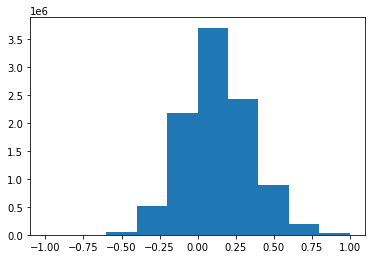

In [7]:
plt.hist(df["Estimated"])

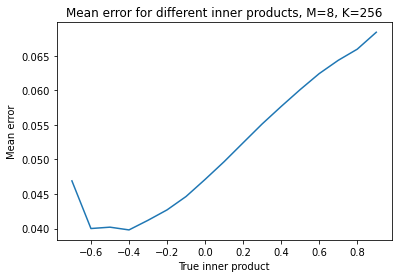

In [3]:

test = h5py.File("g25_angd.hdf5", "r")

inner_prods = test["True_inner_product"][:].reshape(-1)
order = np.argsort(inner_prods)

m8_a = test["8m"]["Asymmetric_distance"][:]

m8_a = m8_a.reshape(-1)

diffs = np.abs(inner_prods - m8_a)

diffs = diffs[order]

ordered_inner = inner_prods[order]

bins = 100
step_size = 0.1

prev = 0
bin = -0.9
xs = []
ys = []
while bin <= 1:
    new = np.argmax(ordered_inner > bin)
    section = diffs[prev:new]
    if section.shape[0]:
        xs.append(bin)
        ys.append(np.mean(section))

    prev = new
    bin += step_size

plt.plot(xs,ys)
plt.title("Mean error for different inner products, M=8, K=256")
plt.xlabel("True inner product")
plt.ylabel("Mean error")
plt.show()

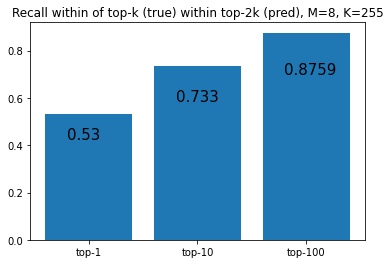

array([0.9544678 , 0.9568176 , 0.9600525 , 0.96139526, 0.9621277 ,
       0.9623413 , 0.9638977 , 0.96698   , 0.9674072 , 0.9684448 ,
       0.96884155, 0.9694214 , 0.9710388 , 0.9711609 , 0.9715271 ,
       0.9722595 , 0.9739685 , 0.97927856, 0.98217773, 0.98657227],
      dtype=float32)

In [14]:
recalls = [0 for _ in range(3)]
for q, ans in zip(test["8m"]["Asymmetric_distance"], test["True_inner_product"]): 
    q_order = np.argsort(q)
    ans_order = np.argsort(ans)
    for i in range(3):
        top_k = 10**i
        intersection = np.intersect1d(q_order[:top_k*2], ans_order[:top_k])
        recalls[i]+= len(intersection)
for i in range(3):
    recalls[i] /= ((10**i)*test["True_inner_product"].shape[0])
plt.title("Recall within of top-k (true) within top-2k (pred), M=8, K=255")
plt.bar(["top-%d" % 10**i for i in range(3)], recalls)

for i in range(3):
    plt.text(x = i-0.2, y = recalls[i]-0.2*recalls[i], s = str(recalls[i]), size = 15)
plt.show()
ordered_inner[-20:].T

In [3]:
pass_filter = h5py.File("g100_pass_filter.hdf5", "r")
ts = np.array(pass_filter["threshholds"])
bks = np.array(pass_filter["threshholds_boot_k"])
estimates = np.array(pass_filter["estimated_inner"])
true = np.array(pass_filter["true_inner"])



In [4]:
true_f = true.reshape(-1)
estimates_f = estimates.reshape(-1)

x1, y1 = [-0.4, 0.4], [-0.4,0.4]
plt.plot(x1,y1)
idcs = [i for i in range(true_f.shape[0])]
sample = np.random.choice(idcs, size=1000, replace=False)

#sns.kdeplot(x = true_f[sample], y = estimates_f[sample])

plt.show()


In [72]:
filenames = { 
            "g100_pass_filter_euc_perm.hdf5": "EP",
            "g100_pass_filter_maha_perm.hdf5": "MP",
            "g100_pass_filter_euc16_perm.hdf5": "E16P",
            "g100_pass_filter_maha16_perm.hdf5": "MP16",
            "g100_pass_filter_euc_no_perm.hdf5": "ENP",
            "g100_pass_filter_maha_no_perm.hdf5": "MNP",
            "g100_pass_filter_euc16_no_perm.hdf5": "E16NP",
            "g100_pass_filter_maha16_no_perm.hdf5": "M16NP"}


g100_pass_filter_euc_perm.hdf5
g100_pass_filter_maha_perm.hdf5
g100_pass_filter_euc16_perm.hdf5
g100_pass_filter_maha16_perm.hdf5
g100_pass_filter_euc_no_perm.hdf5
g100_pass_filter_maha_no_perm.hdf5
g100_pass_filter_euc16_no_perm.hdf5
g100_pass_filter_maha16_no_perm.hdf5


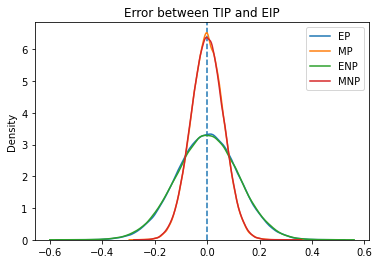

In [79]:
plt.axvline(x=0, linestyle='--')
for fn in filenames:
    print(fn)
    if "16" in fn: continue
    pass_filter = h5py.File(fn, "r")
    #ts = np.array(pass_filter["threshholds"])
    #bks = np.array(pass_filter["threshholds_boot_k"])
    estimates = np.array(pass_filter["estimated_inner"])
    true = np.array(pass_filter["true_inner"])
    diffs = true-estimates
    diffs = diffs.reshape(-1)
    sample = np.random.choice(diffs, size = 100000, replace = False)
    sns.kdeplot(sample, label=filenames[fn])

plt.title("Error between TIP and EIP")
plt.legend()
plt.show()


g100_pass_filter_euc_no_perm.hdf5
g100_pass_filter_euc_perm.hdf5
g100_pass_filter_maha_no_perm.hdf5
g100_pass_filter_maha_perm.hdf5
g100_pass_filter_maha16_perm.hdf5
g100_pass_filter_maha16_no_perm.hdf5


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


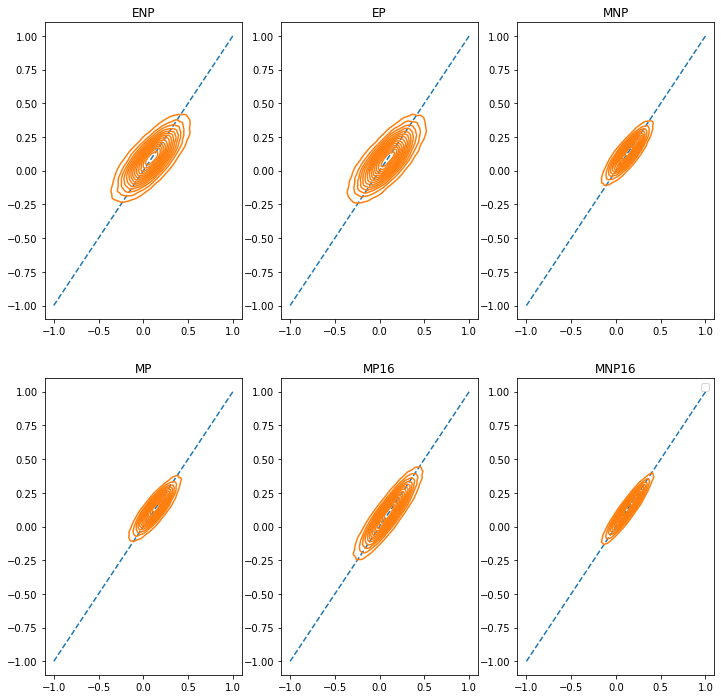

In [5]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12,12))
for fn, ax in zip(filenames.keys(), axes.reshape(-1)):
    print(fn)
    ax.plot([-1,1],[-1,1], linestyle='--')
    pass_filter = h5py.File(fn, "r")
    #ts = np.array(pass_filter["threshholds"])
    #bks = np.array(pass_filter["threshholds_boot_k"])
    estimates = np.array(pass_filter["estimated_inner"]).reshape(-1)
    true = np.array(pass_filter["true_inner"]).reshape(-1)
    order = np.random.permutation(true.shape[0])
    size = 100000
    est = estimates[order][:size]
    t = true[order][:size]
    sns.kdeplot(x = t, y = est, levels=15, ax=ax)
    ax.set_title(filenames[fn])

plt.legend()
plt.show()

g100_pass_filter_euc_perm.hdf5
g100_pass_filter_maha_perm.hdf5
g100_pass_filter_euc16_perm.hdf5
g100_pass_filter_maha16_perm.hdf5
g100_pass_filter_euc_no_perm.hdf5
g100_pass_filter_maha_no_perm.hdf5
g100_pass_filter_euc16_no_perm.hdf5
g100_pass_filter_maha16_no_perm.hdf5


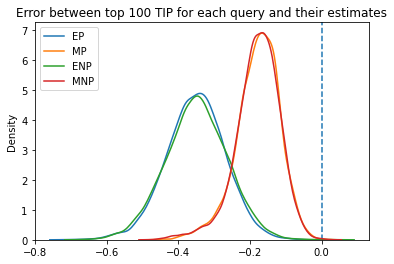

In [80]:
plt.axvline(x=0, linestyle='--')
for fn in filenames.keys():
    print(fn)
    if "16" in fn: continue
    pass_filter = h5py.File(fn, "r")
    #ts = np.array(pass_filter["threshholds"])
    #bks = np.array(pass_filter["threshholds_boot_k"])
    estimates = np.array(pass_filter["estimated_inner"])
    true = np.array(pass_filter["true_inner"])
    order = np.argsort(true)
    order = order[:,-100:]

    top_est = []
    top_true = []
    for i in range(true.shape[0]):
        top_true.append(true[i][order[i]])
        top_est.append(estimates[i][order[i]])
    top_est = np.concatenate(top_est, axis = 0)
    top_true = np.concatenate(top_true, axis = 0)
    diffs = top_est - top_true
    #sample = np.random.choice(diffs, size = 10000, replace = False)
    sns.kdeplot(diffs, label=filenames[fn])
    pass_filter.close()

plt.title("Error between top 100 TIP for each query and their estimates")
plt.legend()
plt.show()

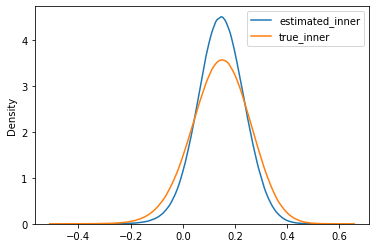

In [4]:
hf = h5py.File("g100_pass_filter_maha_no_perm.hdf5", "r")
sns.kdeplot(hf["estimated_inner"][:5].reshape(-1), label="estimated_inner")
sns.kdeplot(hf["true_inner"][:5].reshape(-1), label="true_inner")
plt.legend()
plt.show()

In [5]:
data = h5py.File("../../data/glove-100-angular.hdf5","r")

In [22]:
top100_diff = 0
for i in range(order.shape[0]):
    top100_diff += len(set(order[i]) - set(data["neighbors"][i]))
print(top100_diff/order.shape[0])

0.2


In [2]:
pass_filter = h5py.File("g100_pass_filter_maha16_no_perm.hdf5","r")
true = np.array(pass_filter["true_inner"])
order = np.argsort(true)
order = order[:,-100:]

In [13]:
pass_filter = h5py.File("glove-25-100k-1k.hdf5","r")
estimates = np.array(pass_filter["4m"]["Asymmetric_distance"])
np.max(estimates)

1.0218811

In [7]:
np.max(estimates[1])

0.65527344

In [3]:
estimates = np.array(pass_filter["estimated_inner"])
ts = pass_filter["threshholds"]
bks = pass_filter["threshholds_boot_k"]
neighs = np.array(data["neighbors"])


NameError: name 'data' is not defined

In [7]:
delta = 0.01
r = np.arange(0.0,0.8,delta)
s = order.shape[1]
recalls = np.zeros(r.shape[0]) 
precisions = np.zeros(r.shape[0]) 
for i in range(order.shape[0]):
    print(i)
    last = 101
    for j, t in enumerate(r):
        mask = estimates[i] > t
        ord = np.argsort(mask)[::-1]
        passed = ord[mask[ord]]
        tp = np.intersect1d(passed,neighs[i]).shape[0]
        assert (tp <= last)
        last = tp

        fp = neighs.shape[1] - tp 
        fn = passed.shape[0] - tp

        assert((tp + fp) == neighs.shape[1])
        recalls[j] += ((tp+0.01)/((tp+fn)+0.01))
        precisions[j] += ((tp+0.01)/((tp + fp)+0.01))
recalls /= order.shape[0]
precisions /= order.shape[0]


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


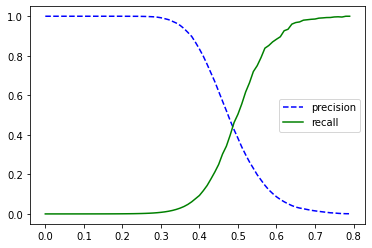

In [8]:
plt.plot(r, precisions, "b--", label = "precision")
plt.plot(r, recalls, "g-", label = "recall")
plt.legend()
plt.show()

In [11]:
rp_data = h5py.File("rec_prec_results.hdf5", "r+")
g = rp_data.create_group("SS")
g.create_dataset("test",data = np.zeros((1)))
g = rp_data.create_group("SS")
print(g)
del g
rp_data.close()

ValueError: Unable to create group (name already exists)

EP
MP
E16P
MP16
ENP
MNP
E16NP
M16NP


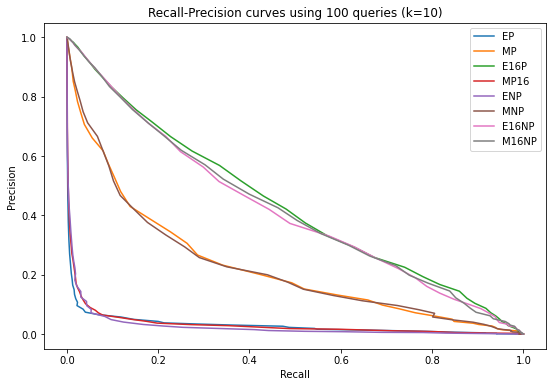

In [15]:
plt.figure(figsize = (9,6))
names = list(pr.filenames.values())
rp_data = h5py.File("rec_prec_results.hdf5", "r")
for name in names:
    print(name)
    try:
        recalls = np.array(rp_data[name]["100"]["recalls"])
        precisions = np.array(rp_data[name]["100"]["precisions"])
        plt.plot(recalls, precisions, label = name)
    except KeyError as e:
        print(e)
rp_data.close()
plt.title("Recall-Precision curves using 100 queries (k=100)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()


In [5]:
rp_data = h5py.File("rec_prec_results.hdf5", "r")
a = np.array(rp_data["LSH"]["100"]["recalls"])
rp_data.close()

[8.45025907e-05 8.45025907e-05 8.45025907e-05 8.45025907e-05
 8.45025907e-05 8.45025907e-05 8.45025907e-05 8.45025907e-05
 8.45025907e-05 8.45025907e-05 8.45025907e-05 8.45025907e-05
 8.45025907e-05 8.45025907e-05 8.45025907e-05 8.45025907e-05
 8.45025907e-05 8.45025907e-05 8.45025907e-05 8.45025907e-05
 8.45025907e-05 8.45025907e-05 8.45025907e-05 8.45025907e-05
 8.45026050e-05 8.44692532e-05 8.42411843e-05 8.23765116e-05
 7.67346011e-05 6.43624166e-05 4.75829197e-05 2.91337127e-05
 1.64558516e-05 7.53994240e-06 3.41818979e-06 2.16015624e-06
 1.20137876e-05 2.65160721e-04 1.32165245e-01 8.21362885e-01
 9.70297030e-01 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00]


Text(0.5, 1.0, 'Precision - Recall plot')

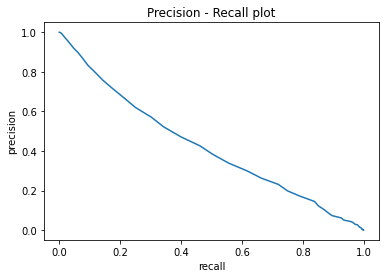

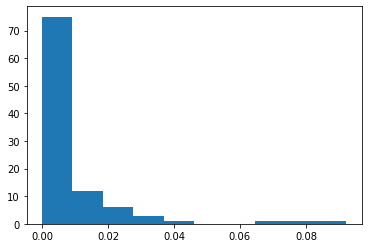

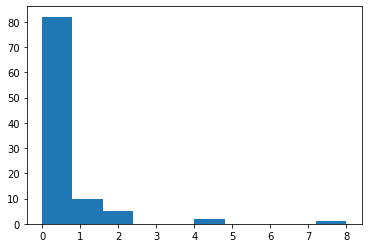

In [74]:
ps = []
missed = []
k = 10
mask = estimates > (ts[1]*1.20)
for i in range(mask.shape[0]):
    pfe = estimates[i][mask[i]]
    p = pfe.shape[0] / estimates[i].shape[0]
    ps.append(p)
    top_true = np.argsort(true[i])[-k:]
    ord = np.argsort(mask[i])[::-1]
    pf = set(ord[mask[i][ord]])
    missed.append(len(set(top_true) - pf))
plt.hist(ps)
plt.show()
plt.hist(missed)
plt.show()

In [71]:
a = np.array(ps)
len(a[a == 0.0])

0

In [55]:
hf = h5py.File("g100_pass_filter_lshq1.hdf5","r")
data = h5py.File("../../data/glove-100-angular.hdf5","r")
a = np.array(hf["bit_diffs"]).T
print(a.shape)
neighs = np.array(data["neighbors"])

(1183514, 32)


In [58]:

print(np.max(np.max(a,axis=1)))

54


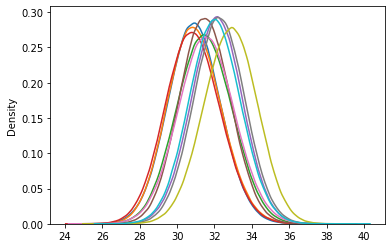

In [17]:
for i in range(10):
    sns.kdeplot(a[i])

In [68]:
ma = np.min(a, axis=1)
r = np.arange(int(np.min(ma)),int(np.max(ma))+1,1)
order = np.argsort(ma)
idcs = np.searchsorted(ma, r, sorter = order)
recalls = np.zeros(r.shape[0])
precisions = np.zeros(r.shape[0])
for j, p_i in enumerate(idcs):
    passed = order[p_i:] 
    tp = np.intersect1d(passed,neighs[0]).shape[0]
    print(passed.shape[0], tp)
    fp = neighs.shape[1] - tp 
    fn = passed.shape[0] - tp
    recalls[j] += ((tp+0.01)/((tp+fn)+0.01))
    precisions[j] += ((tp+0.01)/((tp + fp)+0.01))

1183514 100
1183513 100
1183505 100
1183482 100
1183378 100
1182988 99
1182047 99
1179466 99
1173061 99
1158238 98
1126823 92
1066476 84
959464 74
793435 60
574334 46
339072 33
150036 11
45069 4
8245 1
777 0
51 0
2 0


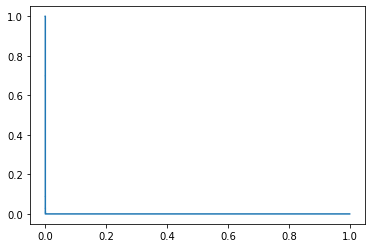

In [67]:
plt.plot(recalls, precisions)

In [27]:
recalls

array([8.45025907e-05, 8.45025907e-05, 8.45025907e-05, 8.45025907e-05,
       8.45025907e-05, 8.45025907e-05, 8.45025907e-05, 8.45025907e-05,
       8.45025907e-05, 8.45025907e-05, 8.45025907e-05, 8.45025907e-05,
       8.45025907e-05, 8.45025907e-05, 8.45025907e-05, 8.45025907e-05,
       8.45025907e-05, 8.45025907e-05, 8.45025907e-05, 8.45025907e-05,
       8.45025907e-05, 8.45025907e-05, 8.45025907e-05, 8.45025907e-05,
       8.45025907e-05, 8.45025907e-05, 8.45025907e-05, 8.45025907e-05,
       8.45025907e-05, 8.45025907e-05, 8.45025907e-05, 8.45025907e-05,
       8.45025907e-05, 8.45025907e-05, 8.45025907e-05, 8.45025907e-05,
       8.45025907e-05, 8.45025907e-05, 8.45025907e-05, 8.45025907e-05,
       8.45025907e-05, 8.45025907e-05, 8.45025907e-05, 8.45025907e-05,
       8.45025907e-05, 8.45025907e-05, 8.45025907e-05, 8.45025907e-05,
       8.45025907e-05, 8.45025907e-05, 8.45025907e-05, 8.45025907e-05,
       8.45025907e-05, 8.45025907e-05, 8.45025907e-05, 8.45025907e-05,
      

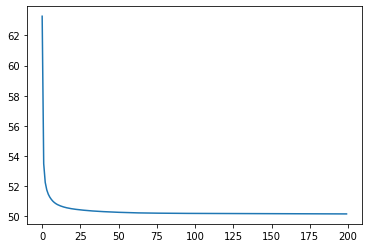

In [4]:
hf = h5py.File("inertia_runs.hdf5", "r")
plt.plot(np.arange(0,200,1), np.array(hf["mahalanobis"]))